In [1]:
# %matplotlib agg

# Performing Partial dependence analysis on the Medium pH media formulations


In [2]:
# Importing common packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

In [3]:
# Importing all the sklearn packages
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [4]:
# Setting the formatting
plt.rcParams["font.family"]="Arial"
plt.rcParams["font.size"]=12
plt.rcParams["axes.labelsize"]=12
plt.rcParams["legend.fontsize"]=12
plt.rcParams["ytick.labelsize"]=10
plt.rcParams["xtick.labelsize"]=10

In [5]:
# Uploading the file 
root_dir = "."
file_name="SVM-2-Report_09-17-24_2.csv"
col_list = list(range(0,5))
data_path = os.path.join(root_dir,file_name)
df_all=pd.read_csv(data_path,usecols=col_list)
df_all

,Glucose,Sucrose,Total Sugar,pH,Fold Increase
0,0,0,0,lo,1.57
1,0,10,10,lo,6.45
2,0,20,20,lo,5.09
3,0,30,30,lo,4.65
4,0,40,40,lo,7.25
...,...,...,...,...,...
70,40,0,40,hi,32.06
71,40,10,50,hi,29.16
72,40,20,60,hi,24.91
73,40,30,70,hi,25.35


In [6]:
# Spliting the df based on the pH
df_med = df_all[df_all["pH"]=="md"]

In [7]:
#Finding the best parameter
def find_best_params(x_train,x_test,y_train,y_test,c_vals=None,g_vals=None,kernel="rbf"):
    
    if c_vals is None:
        c_vals= np.logspace(-1,3,5)
        
    if g_vals is None:
        g_vals= np.logspace(2,-4,7)
        
    results = {}
    
    for i in c_vals:
        
        for j in g_vals:
            
            # Defining the model
            svr = SVR(C=i,gamma=j,kernel=kernel)
            
            #Training the model
            svr.fit(x_train,y_train)
            
            r2 = round(svr.score(x_train,y_train),4)
            
            results[(i,j)]=r2
            
    max_r = max(results.values())
    best_params = [params for params, r2 in results.items() if r2==max_r]
    best_c,best_gamma=best_params[0]
    return best_c, best_gamma
    

In [8]:
# Test train spl
x_cols = ["Glucose","Sucrose"]
y_cols=["Fold Increase"]
x_train_med,x_test_med,y_train_med,y_test_med = train_test_split(df_med[x_cols],df_med[y_cols],test_size=0.1,random_state=1)

# Selecting all data for training
x_all_med,y_all_med=df_med[x_cols],df_med[y_cols]

In [9]:
# Finding all the max values

scalerG = np.max(df_all["Glucose"], axis=0)
Glucose_max = np.max(df_all["Glucose"],axis=0)
Sucrose_max = np.max(df_all["Sucrose"],axis=0)
scaler_y_med = max(df_med["Fold Increase"])


# Making a divisor for x_col Data Frame
divisors = {"Glucose":Glucose_max,
            "Sucrose":Sucrose_max,
          }

In [10]:
#Med ph
x_test_med_nor=x_test_med.div(divisors)
x_train_med_nor=x_train_med.div(divisors)
x_all_med_nor=x_all_med.div(divisors)


In [11]:
# Normalizing the dependent variable
y_test_med_nor=np.array(y_test_med/scaler_y_med)
y_train_med_nor=np.array(y_train_med/scaler_y_med)
y_all_med_nor=np.array(y_all_med/scaler_y_med)


In [12]:
# Finding the best parameters
c_med,gamma_med=find_best_params(x_all_med_nor,x_test_med_nor,y_all_med_nor.ravel(),y_test_med_nor.ravel())
print(f"C:{c_med} and Gamma:{gamma_med}")


C:100.0 and Gamma:1.0


In [13]:
# Building the model for medium pH
svr_med = SVR(C=c_med,gamma=gamma_med,kernel="rbf")
svr_med.fit(x_all_med_nor,y_all_med_nor.ravel())

SVR(C=100.0, gamma=1.0)

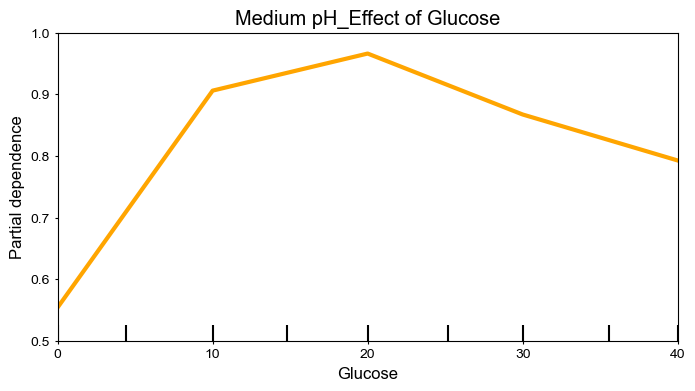

In [14]:
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Assuming x_all_lo_nor is a DataFrame with a "Glucose" column
PartialDependenceDisplay.from_estimator(
    svr_med,                     # Your trained SVR model
    x_all_med_nor,               # Input dataset (DataFrame or numpy array)
    features=["Glucose"],       # Feature(s) for partial dependence
    kind="average",                # "both" for ICE and PDP 
    # centered = True,
    pd_line_kw={"color": "orange",
                "lw":3,
                "linestyle":"-"},     # Style for PDP line
    ax=ax                       # Matplotlib Axes to plot on
)

plt.xlim(0,1)
plt.ylim(0.5,1)
plt.xticks(ticks=[0,0.25,0.5,0.75,1],
          labels=[0,10,20,30,40])
plt.tick_params(axis='both', which='both', direction='out', length=2)
plt.title("Medium pH_Effect of Glucose")

plt.show()

In [15]:
pdp_pts_med_glu = partial_dependence(svr_med,                     # Your trained SVR model
    x_all_med_nor,               # Input dataset (DataFrame or numpy array)
    features=["Glucose"],       # Feature(s) for partial dependence
    percentiles =(0,1),
    grid_resolution = 100,                 
    kind="both",                # "both" for ICE and PDP
    )

In [16]:
pdp_pts_med_glu

{'grid_values': [array([0.  , 0.25, 0.5 , 0.75, 1.  ])],
 'average': array([[0.55415302, 0.90614126, 0.96632038, 0.86739804, 0.79275803]]),
 'individual': array([[[0.14843232, 0.78242598, 1.03600543, 1.00305753, 0.90182018],
         [0.52410516, 0.93900452, 1.00596489, 0.88488645, 0.7993421 ],
         [0.7207097 , 0.97933867, 0.94623566, 0.79904769, 0.73710514],
         [0.73375045, 0.94438697, 0.91700071, 0.79718392, 0.74348061],
         [0.64376747, 0.88555017, 0.9263952 , 0.85281463, 0.78204213],
         [0.14843232, 0.78242598, 1.03600543, 1.00305753, 0.90182018],
         [0.52410516, 0.93900452, 1.00596489, 0.88488645, 0.7993421 ],
         [0.7207097 , 0.97933867, 0.94623566, 0.79904769, 0.73710514],
         [0.73375045, 0.94438697, 0.91700071, 0.79718392, 0.74348061],
         [0.64376747, 0.88555017, 0.9263952 , 0.85281463, 0.78204213],
         [0.14843232, 0.78242598, 1.03600543, 1.00305753, 0.90182018],
         [0.52410516, 0.93900452, 1.00596489, 0.88488645, 0.79934

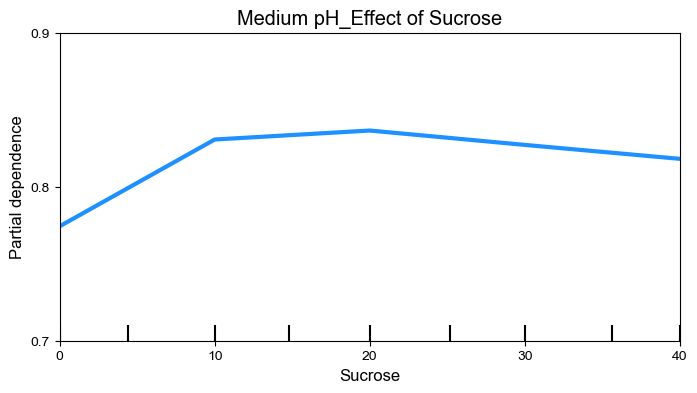

In [17]:
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Assuming x_all_lo_nor is a DataFrame with a "Glucose" column
PartialDependenceDisplay.from_estimator(
    svr_med,                     # Your trained SVR model
    x_all_med_nor,               # Input dataset (DataFrame or numpy array)
    features=["Sucrose"],       # Feature(s) for partial dependence
    kind="average",                # "both" for ICE and PDP
    # centered=True,             # Disable centering
    ice_lines_kw={"color": "black"},  # Style for ICE lines
    pd_line_kw={"color": "DodgerBlue",
                "lw":3,
                "linestyle":"-"},     # Style for PDP line
    ax=ax                       # Matplotlib Axes to plot on
)

plt.xlim(0,1)
plt.ylim(0.7,0.9)
plt.xticks(ticks=[0,0.25,0.5,0.75,1],
          labels=[0,10,20,30,40])

plt.yticks(ticks=[0.7,0.8,0.9],
          labels=[0.7,0.8,0.9])
plt.title("Medium pH_Effect of Sucrose")
plt.show()

In [18]:
pdp_pts_med_suc = partial_dependence(svr_med,                     # Your trained SVR model
    x_all_med_nor,               # Input dataset (DataFrame or numpy array)
    features=["Sucrose"],       # Feature(s) for partial dependence
    percentiles =(0,1),
    grid_resolution = 100,                 
    kind="both",                # "both" for ICE and PDP
    )

In [19]:
pdp_pts_med_suc

{'grid_values': [array([0.  , 0.25, 0.5 , 0.75, 1.  ])],
 'average': array([[0.77434829, 0.83066062, 0.83648737, 0.82716053, 0.81811392]]),
 'individual': array([[[0.14843232, 0.52410516, 0.7207097 , 0.73375045, 0.64376747],
         [0.14843232, 0.52410516, 0.7207097 , 0.73375045, 0.64376747],
         [0.14843232, 0.52410516, 0.7207097 , 0.73375045, 0.64376747],
         [0.14843232, 0.52410516, 0.7207097 , 0.73375045, 0.64376747],
         [0.14843232, 0.52410516, 0.7207097 , 0.73375045, 0.64376747],
         [0.78242598, 0.93900452, 0.97933867, 0.94438697, 0.88555017],
         [0.78242598, 0.93900452, 0.97933867, 0.94438697, 0.88555017],
         [0.78242598, 0.93900452, 0.97933867, 0.94438697, 0.88555017],
         [0.78242598, 0.93900452, 0.97933867, 0.94438697, 0.88555017],
         [0.78242598, 0.93900452, 0.97933867, 0.94438697, 0.88555017],
         [1.03600543, 1.00596489, 0.94623566, 0.91700071, 0.9263952 ],
         [1.03600543, 1.00596489, 0.94623566, 0.91700071, 0.92639